In [11]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import partialmethod

In [3]:
true_pars = game.true_pars
model = game.physical_model()

In [16]:
f = lambda t: jnp.diag(model.fim(true_pars, t))

In [17]:
f(3.5)

Array([0.1428585 , 0.09578159, 0.4793376 , 0.29470453], dtype=float32)

In [30]:
times = jnp.linspace(0.0001, 150, 10000)

In [31]:
diags_fim = jax.vmap(f)(times)

In [35]:
diags_fim.shape

(10000, 4)

In [43]:
max_times_locs = jnp.argmax(diags_fim, axis=0)
best_times = times[max_times_locs]

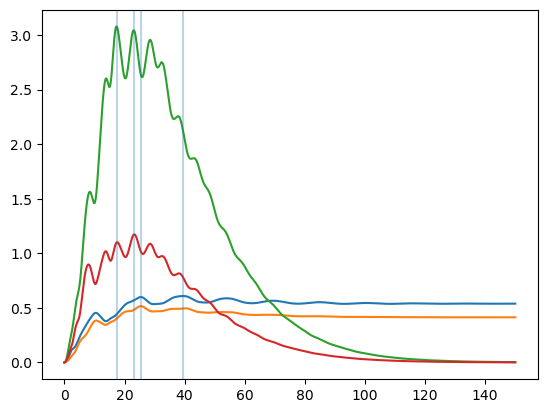

In [47]:
plt.plot(times, diags_fim)
for i in list(best_times):
    plt.axvline(x=i, alpha=0.3)
plt.show()

In [50]:
best_fim = jnp.diag(jax.vmap(f)(best_times))

In [53]:
best_fim

Array([0.60880256, 0.51566666, 3.0778577 , 1.1730341 ], dtype=float32)

In [58]:
errors = 1 / np.sqrt(best_fim) / np.sqrt(500)

In [59]:
errors

array([0.05731612, 0.0622774 , 0.02549122, 0.04129141], dtype=float32)

In [60]:
example_estimates = jnp.array([0.32137, 0.36799, 0.05970, -0.32731])

In [61]:
example_estimates + errors

Array([ 0.37868613,  0.4302674 ,  0.08519123, -0.28601858], dtype=float32)

In [62]:
example_estimates - errors

Array([ 0.26405388,  0.30571258,  0.03420877, -0.3686014 ], dtype=float32)

In [67]:
1 / jnp.linalg.norm(best_fim)

Array(0.29506654, dtype=float32)

In [69]:
approximated_fim_times = diags_fim = jax.vmap(
    lambda a, b: jnp.diag(model.fim(a, b)), in_axes=(None, 0)
)(
    example_estimates,
    times,
)

In [78]:
worst_diags_fim_up = jax.vmap(
    lambda a, b: jnp.diag(model.fim(a, b)), in_axes=(None, 0)
)(
    example_estimates + errors,
    times,
)
worst_diags_fim_down = jax.vmap(
    lambda a, b: jnp.diag(model.fim(a, b)), in_axes=(None, 0)
)(
    example_estimates - errors,
    times,
)

In [110]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

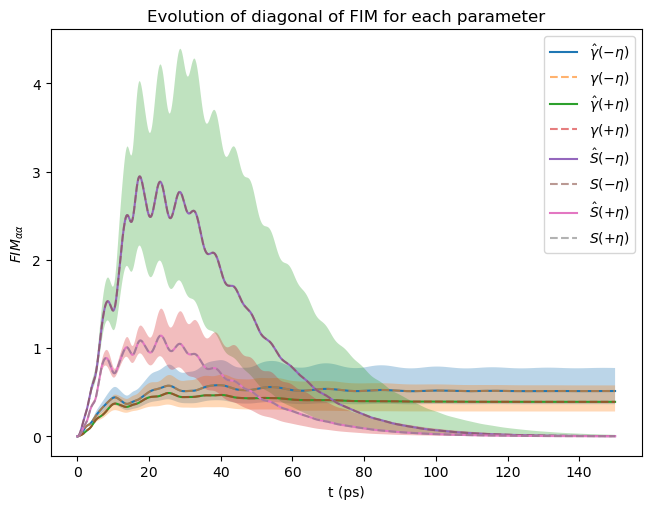

In [112]:
for i in range(4):
    plt.plot(times, approximated_fim_times[:, i], label=names_hat[i])
    plt.fill_between(
        times, worst_diags_fim_up[:, i], worst_diags_fim_down[:, i], alpha=0.3
    )
    plt.plot(times, diags_fim[:, i], "--", label=names_true[i], alpha=0.6)

plt.legend()
plt.tight_layout()
plt.xlabel("t (ps)")
plt.ylabel("$FIM _{\\alpha \\alpha}$")
plt.title("Evolution of diagonal of FIM for each parameter")
plt.show()

Let's see how we can relate this with the best covariance found in the experiments

In [117]:
run_results = joblib.load("../results/run_2024-01-02_18:33:28_results.job")
run_model = joblib.load("../results/run_2024-01-02_18:33:28_model.job")

true_parameters = true_pars

number_of_samples = 500

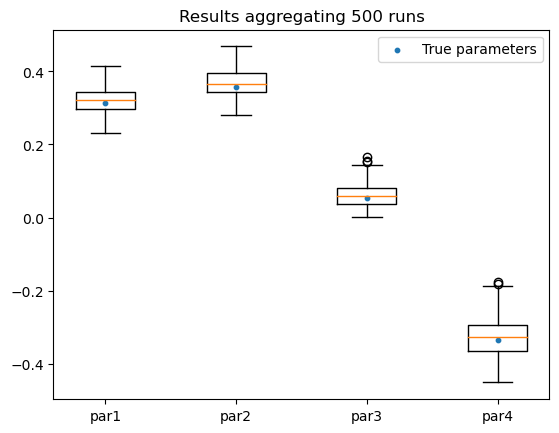

In [116]:
final_cov_matrix = jax.vmap((lambda a, b: a[b]), in_axes=(0, 0))(
    run_results.cov_array, run_results.iteration
)

final_cov_norm = jax.vmap(jnp.linalg.norm, in_axes=(0))(final_cov_matrix)

final_estimates = jax.vmap((lambda a, b: a[b]), in_axes=(0, 0))(
    run_results.estimates_array, run_results.iteration
)

df = pd.DataFrame(final_estimates, columns=["par1", "par2", "par3", "par4"])

df_true_pars = pd.DataFrame(
    true_parameters[np.newaxis, :], columns=["par1", "par2", "par3", "par4"]
)

plt.style.use("default")
colnames = ["par1", "par2", "par3", "par4"]
plt.boxplot(df, labels=colnames, positions=range(len(df.columns)))
plt.scatter(
    colnames, true_parameters, label="True parameters", marker="o", s=10
)
# plt.plot(df_true_pars)
plt.title("Results aggregating 500 runs")
plt.legend()
plt.show()


In [118]:
iters = np.arange(0, 4000)

def f_to_replace_with_nan(covariances, iteration):
    arr = np.array(covariances)
    arr[iteration + 1 :] = np.nan
    return arr

np_cov_arr = np.array(run_results.cov_array)
np_estimates_arr = np.array(run_results.estimates_array)
np_iter = np.array(run_results.iteration)

for i in range(500):
    np_cov_arr[i] = f_to_replace_with_nan(np_cov_arr[i], np_iter[i])
    np_estimates_arr[i] = f_to_replace_with_nan(
        np_estimates_arr[i], np_iter[i]
    )

In [119]:
@jit
def jeje():
    re = []
    for i in range(500):
        re.append(vmap(jnp.linalg.norm, 0)(np_cov_arr[i]))
    return re

re = jeje()
re = np.array(re)

In [120]:
mean_per_iteration = np.nanmean(re, axis=0)
median_per_iteration = np.nanmedian(re, axis=0)
std_per_iteration = np.nanstd(re, axis=0)

def fun_to_fit(iteration, a, b):
    return -a * iteration**b


fitting_estimates_cov, fitting_covariances_cov = scipy.optimize.curve_fit(
    fun_to_fit, iters[1:], mean_per_iteration[1:]
)



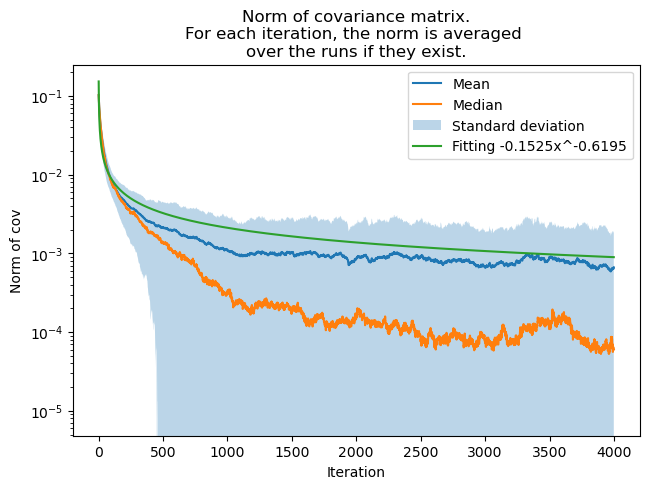

In [121]:
plt.plot(iters[1:], mean_per_iteration[1:], label="Mean")
plt.plot(iters[1:], median_per_iteration[1:], label="Median")
plt.fill_between(
    x=iters,
    y1=mean_per_iteration - std_per_iteration,
    y2=mean_per_iteration + std_per_iteration,
    alpha=0.3,
    label="Standard deviation",
)

plt.plot(
    iters[1:],
    fun_to_fit(iters[1:], *fitting_estimates_cov),
    label=f"Fitting {fitting_estimates_cov[0]:.4f}x^{fitting_estimates_cov[1]:.4f}",
)

plt.yscale("log")
plt.legend()
plt.title(
    "Norm of covariance matrix.\nFor each iteration, the norm is averaged \nover the runs if they exist."
)
plt.tight_layout()
plt.xlabel("Iteration")
plt.ylabel("Norm of cov")
plt.show()

In [122]:
# Let's take for example mean value between iteration 1500 and 3000 using the mean array

In [127]:
mean_per_iteration[1500:2500].mean()
# This is the mean norm when the algorithm converges

0.00092084205

In [133]:
# Is this related to the best case fim and all that shit?

1/(jnp.linalg.norm(best_fim))/(2000)

Array(0.00014753, dtype=float32)